In [ ]:
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import userdata
    repo_name = 'dgcnz/dl2'
    url = f"https://{userdata.get('gh_pat')}@github.com/{repo_name}.git"
    !git clone {url}
    print("\nCurrent Directory:")
    %cd dl2
    #!pip install torch torchvision numpy matplotlib git+https://github.com/AMLab-Amsterdam/lie_learn escnn scipy
    !pip install torchvision git+https://github.com/AMLab-Amsterdam/lie_learn escnn lightning wandb git+https://github.com/dgcnz/neuralyze
    #!pip install -r requirements.txt


else: # automatically checks if the current directory is 'repo name'
    curdir = Path.cwd()
    print("Current Directory", curdir)
    assert curdir.name == "dl2" or curdir.parent.name == "dl2", "Notebook cwd has to be on the project root"
    if curdir.name == "notebooks":
        %cd ..

Cloning into 'dl2'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 204 (delta 76), reused 143 (delta 42), pack-reused 0
Receiving objects: 100% (204/204), 102.34 KiB | 6.02 MiB/s, done.
Resolving deltas: 100% (76/76), done.

Current Directory:
/content/dl2
  Cloning https://github.com/AMLab-Amsterdam/lie_learn to /tmp/pip-req-build-feuxitkd
  Running command git clone --filter=blob:none --quiet https://github.com/AMLab-Amsterdam/lie_learn /tmp/pip-req-build-feuxitkd
  Resolved https://github.com/AMLab-Amsterdam/lie_learn to commit 1ccc2106e402d517a29de5438c9367c959e67338
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/dgcnz/neuralyze to /tmp/pip-req-build-2hg5yuuv
  Running command git clone --filter=blob:none --quiet https

In [ ]:
import wandb
wandb.login(key=userdata.get('wandb_key'))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import sys
sys.path.append('../')

import torch

from escnn import gspaces
from escnn import nn
import os
from torch import optim, utils, Tensor
#from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L
from lightning.pytorch.loggers import WandbLogger

from src.models.image_module import ImageLightningModule
from src.data.rotated_mnist_datamodule import MnistRotDataset

from torch.utils.data import Dataset
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
from torchvision.transforms import InterpolationMode
from neuralyze import get_hessian_max_spectrum

from torchmetrics import MaxMetric, MeanMetric
from torchmetrics.classification.accuracy import Accuracy

from typing import Any, Dict, Tuple

device = 'cuda' if torch.cuda.is_available() else 'cpu'
L.seed_everything(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

###write lightning module def

In [ ]:
# define the LightningModule
class PlModule(L.LightningModule):
    def __init__(self, net):
        super().__init__()
        self.save_hyperparameters()

        self.net = net

        loss_fn = torch.nn.CrossEntropyLoss()

        # num classes
        num_classes = 10 #net.layers[-1].out_features #if this break hardcode to one

        # metric objects for calculating and averaging accuracy across batches
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for averaging loss across batches
        self.train_acc_mean = MeanMetric()
        self.val_acc_mean = MeanMetric()
        self.test_acc_mean = MeanMetric()


        # for tracking best so far validation accuracy
        self.val_acc_best = MaxMetric()

    def model_step(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Perform a single model step on a batch of data.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target labels.

        :return: A tuple containing (in order):
            - A tensor of losses.
            - A tensor of predictions.
            - A tensor of target labels.
        """
        x, y = batch
        logits = self.net(x)
        loss =  torch.nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
      """Perform a single test step on a batch of data from the test set.

      :param batch: A batch of data (a tuple) containing the input tensor of images and target
          labels.
      :param batch_idx: The index of the current batch.
      """
      #print(batch_index)
      loss, preds, targets = self.model_step(batch)

      # update and log metrics
      self.test_loss(loss)
      self.test_acc_mean(self.test_acc(preds, targets))
      self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
      self.log("test/acc", self.test_acc_mean, on_step=False, on_epoch=True, prog_bar=True)

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        """Perform a single validation step on a batch of data from the validation set.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target
            labels.
        :param batch_idx: The index of the current batch.
        """
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        self.val_loss(loss)
        self.val_acc_mean(self.val_acc(preds, targets))

        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc_mean, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self) -> None:
       self.val_acc_mean.reset()

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
      """Perform a single training step on a batch of data from the training set.

      :param batch: A batch of data (a tuple) containing the input tensor of images and target
          labels.
      :param batch_idx: The index of the current batch.
      :return: A tensor of losses between model predictions and targets.
      """
      loss, preds, targets = self.model_step(batch)

      # update and log metrics
      self.train_loss(loss)
      self.train_acc_mean(self.train_acc(preds, targets))

      self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
      self.log("train/acc", self.train_acc_mean, on_step=False, on_epoch=True, prog_bar=True)

      # return loss or backpropagation will fail
      return loss

    def on_train_epoch_end(self) -> None:
        "Lightning hook that is called when a training epoch ends."
        self.train_acc_mean.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), lr=5e-5, weight_decay=1e-5)
        return optimizer

### Write both the model definitions

In [ ]:
class C8SteerableCNN(torch.nn.Module):

    def __init__(self, n_classes=10):

        super(C8SteerableCNN, self).__init__()
        #self.save_hyperparameters()


        # the model is equivariant under rotations by 45 degrees, modelled by C8
        self.r2_act = gspaces.rot2dOnR2(N=8)

        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type

        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 29, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )

        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )

        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)

        self.gpool = nn.GroupPooling(out_type)

        # number of output channels
        c = self.gpool.out_type.size

        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(c, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )

    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        x = nn.GeometricTensor(input, self.input_type)

        # apply each equivariant block

        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)

        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)

        x = self.block5(x)
        x = self.block6(x)

        # pool over the spatial dimensions
        x = self.pool3(x)

        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor

        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))

        return x

In [ ]:
import torch
import torch.nn.functional as F
#V2

class BasicInvertedBottleneckBlockV2(torch.nn.Module):
    def __init__(self, Cin, N, Cout, downsample = False, first_block = False):
        super(BasicInvertedBottleneckBlockV2, self).__init__()

        kernel_size = 3
        padding = 1

        if first_block:
          kernel_size = 7
          padding = 3

        self.block = torch.nn.Sequential(
          torch.nn.Conv2d(Cin, N, kernel_size=kernel_size, stride=1, padding=padding),
          torch.nn.BatchNorm2d(N), #idk which BN to use
          torch.nn.ELU(inplace=True),
          #dit is de enige logische interpretatie van appendix H4 die ik kan bedenken. of miss dit of downsample maar nooit beide? dat is denk ik logischer
          #torch.nn.Conv2d(N, Cout, kernel_size=kernel_size, stride=1, padding=padding)
        )

        self.one_by_one: bool = (Cin != Cout)

        if self.one_by_one:
            self.conv1x1 = torch.nn.Conv2d(Cin, Cout, kernel_size=1, stride=1, padding=0)

        self.downsample = downsample
        if self.downsample:
          #for this one I'm guessing
          self.second_conv = torch.nn.Conv2d(N, Cin, kernel_size=kernel_size, stride=2, padding=padding)
          self.avg_pool = torch.nn.AvgPool2d(kernel_size=kernel_size, stride=2, padding=padding)
        else:
          self.second_conv = torch.nn.Conv2d(N, Cin, kernel_size=kernel_size, stride=1, padding=padding) #idk setting kernel size to one here does massively reduce the number of parameters

    def forward(self, x):
        out = self.block(x)
        #N Channels
        #print('before downsample')
        #print(out.shape)
        #print(x.shape)

        out = self.second_conv(out)
        #C_in Channels

        if self.downsample:
          #if the second convolution downsamples
          #then the size of the image changes
          #so we must decrease x in size
          #to be able to add it up
          x = self.avg_pool(x)


        #print('afterdownsample')
        #print(out.shape)
        #print(x.shape)

        #print('afteronebyone')
        #print(out.shape)
        #print(x.shape)
        skip_connection = out + x
        if self.one_by_one:
           skip_connection = self.conv1x1(skip_connection)
           #C_out

        return skip_connection

class CNN(torch.nn.Module):
    def __init__(self, backbone_channels, residual_channels, n_classes):
        super(CNN, self).__init__()
        self.backbone_channels = backbone_channels
        self.residual_channels = residual_channels
        self.blocks = self._make_blocks()
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3, stride=1)

        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )

    def _make_blocks(self):
        blocks = []
        for i in range(len(self.backbone_channels)):
            Cin = self.backbone_channels[i]
            N = self.residual_channels[i]
            # this next part is because their explanation doesnt seem to include the channel output size of the last block. So we set it to be the same as the input
            if i < len(self.backbone_channels) - 1:
                Cout = self.backbone_channels[i + 1]
            else:
                Cout = 32 #this is also very vague from the og paper

            #print('hello', i)
            if i == 0:
              #print('i = 0 -------------------------')
              blocks.append(BasicInvertedBottleneckBlockV2(Cin, N, Cout, first_block=True))

            elif (i+1) % 2 == 0: #every two layers this is true
              #print('True-------------------------------------------------------------')
              blocks.append(BasicInvertedBottleneckBlockV2(Cin, N, Cout, downsample=True))

            else:
              #print('normal case =======================')
              blocks.append(BasicInvertedBottleneckBlockV2(Cin, N, Cout))
        return torch.nn.Sequential(*blocks)

    def forward(self, x):
        out = self.blocks(x)
        out = self.max_pool(out)
        #print(out.shape)
        out = self.fully_net(out.flatten(start_dim = 1))

        return out

# Example usage:
backbone_channels = [1, 21, 54, 72, 108, 168]  # These are the C_in's
residual_channels = [96, 192, 288, 288, 576, 576]  # These are the upsampled N's
cnn_model = CNN(backbone_channels, residual_channels, n_classes = 10).to(device)


#### Plot fn

### C8 steerable hessian

In [ ]:
run = wandb.init()
checkpoints = []

#put the 15 checkpoints in a list
for i in range(15):
  checkpoint = run.use_artifact('uva-dl2/C8steerable_RotMNIST/model-u3vh8ed9:v' + str(i), type='model')
  dir = checkpoint.download()
  checkpoints.append(torch.load(dir + '/model.ckpt'))

# finish wandb run
run.finish()

wandb: Downloading large artifact model-u3vh8ed9:v0, 167.44MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5
wandb: Downloading large artifact model-u3vh8ed9:v1, 167.44MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.9
wandb: Downloading large artifact model-u3vh8ed9:v2, 167.44MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:4.0
wandb: Downloading large artifact model-u3vh8ed9:v3, 167.44MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.7
wandb: Downloading large artifact model-u3vh8ed9:v4, 167.44MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7
wandb: Downloading large artifact model-u3vh8ed9:v5, 167.44MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5
wandb: Downloading large artifact model-u3vh8ed9:v6, 167.44MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.2
wandb: Downloading large artifact model-u3vh8ed9:v7, 167.44MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.0


In [ ]:
model = C8SteerableCNN().to(device)
equivariantmodel = PlModule(model)
equivariantmodel.load_state_dict(checkpoints[1]['state_dict'])

<All keys matched successfully>

In [ ]:
print(len(checkpoints))

15


In [ ]:
#get dataloader
#define transforms
pad = Pad((0, 0, 1, 1), fill=0)

resize1 = Resize(87)
resize2 = Resize(29)

totensor = ToTensor()

train_transform = Compose([
    pad,
    resize1,
    RandomRotation(180., interpolation=InterpolationMode.BILINEAR, expand=False),
    resize2,
    totensor,
])

test_transform = Compose([
    pad,
    totensor,
])


dataset = MnistRotDataset("data/mnist/",download=True, transform=train_transform)
train_loader1 = utils.data.DataLoader(dataset, batch_size = 64, num_workers=7)

In [ ]:
## evaluate the test set at the checkpoints
test_transform = Compose([
    pad,
    totensor,
])


test_dataset = MnistRotDataset("data/mnist/",download=False,train=False, transform=test_transform)

test_loader = utils.data.DataLoader(test_dataset, batch_size = 64, num_workers=7)

trainer = L.Trainer()
for checkpoint in checkpoints:
  equivariantmodel = PlModule(model)
  equivariantmodel.load_state_dict(checkpoint['state_dict'])

  trainer.test(model=equivariantmodel, dataloaders=test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:44: attribute 'net' removed from hparams because it cannot be pickled
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9718869924545288     │
│         test/loss         │    0.10884393006563187    │
└───────────────────────────┴───────────────────────────┘

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.975343644618988     │
│         test/loss         │    0.09059832990169525    │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9775015711784363     │
│         test/loss         │    0.08196328580379486    │
└───────────────────────────┴───────────────────────────┘

In [65]:
#get criterion
loss_fn = torch.nn.CrossEntropyLoss()
weight_decay = 1e-5
top_k = 1

spectrum = get_hessian_max_spectrum(
    model=equivariantmodel.net,
    criterion=loss_fn,
    train_dataloader=train_loader1,
    weight_decay=weight_decay,
    top_k=top_k,
    cuda=True,
    verbose=False,
)
# plotting etc...
print(spectrum)

[333.031982421875, 254.37513732910156, 395.8107604980469, 287.7648010253906, 401.6199951171875, 414.1491394042969, 410.441162109375, 498.984619140625, 530.0369262695312, 296.0187072753906, 387.8148498535156, 274.1049499511719, 766.5582885742188, 465.79052734375, 422.53411865234375, 417.55615234375, 403.8988952636719, 532.3838500976562, 720.0921630859375, 479.35028076171875, 528.6215209960938, 454.8970947265625, 397.3937683105469, 409.3011474609375, 329.2708435058594, 510.29620361328125, 758.2106323242188, 740.628662109375, 572.430419921875, 692.5631103515625, 520.3715209960938, 182.6204833984375, 590.7817993164062, 523.0174560546875, 613.02099609375, 503.0660400390625, 579.7132568359375, 490.16015625, 331.343994140625, 418.6534118652344, 438.0970458984375, 506.46990966796875, 538.7897338867188, 290.7578430175781, 413.21563720703125, 481.84820556640625, 541.3834838867188, 677.215576171875, 747.4902954101562, 467.7528076171875, 739.9113159179688, 560.5393676757812, 512.3710327148438, 303

0


Text(0.5, 1.0, 'Density Plot')

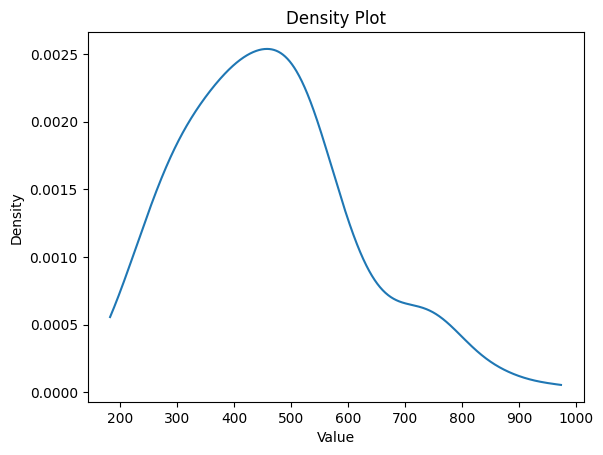

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

print(sum(np.array(spectrum) < 0))

# Create kernel density estimate
kde = gaussian_kde(spectrum)

# Create x values for the plot
x = np.linspace(min(spectrum), max(spectrum), 1000)

# Compute the density estimate
density = kde(x)

# Plot density estimate as a line
plt.plot(x, density)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot')

###Do for CNN

In [ ]:
run = wandb.init()
cnn_checkpoints = []

#put the 15 checkpoints in a list
for i in range(15):
  checkpoint = run.use_artifact('uva-dl2/CNN_RotMNIST/model-4l530hst:v' + str(i), type='model')
  dir = checkpoint.download()
  cnn_checkpoints.append(torch.load(dir + '/model.ckpt'))


# finish wandb run
run.finish()

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [ ]:
print(len(cnn_checkpoints))
cnn = PlModule(cnn_model)
cnn.load_state_dict(cnn_checkpoints[12]['state_dict'])

15


<All keys matched successfully>

In [ ]:
pad = Pad((0, 0, 1, 1), fill=0)

resize1 = Resize(87)
resize2 = Resize(29)

totensor = ToTensor()

train_transform = Compose([
    pad,
    resize1,
    RandomRotation(180., interpolation=InterpolationMode.BILINEAR, expand=False),
    resize2,
    totensor,
])

test_transform = Compose([
    pad,
    totensor,
])


dataset = MnistRotDataset("data/mnist/",download=True, transform=train_transform)
train_loader1 = utils.data.DataLoader(dataset, batch_size = 64, num_workers=7)

In [ ]:
#get criterion
loss_fn = torch.nn.CrossEntropyLoss()
weight_decay = 1e-5
top_k = 1

spectrum = get_hessian_max_spectrum(
    model=cnn.net,
    criterion=loss_fn,
    train_dataloader=train_loader1,
    weight_decay=weight_decay,
    top_k=top_k,
    cuda=True,
    verbose=False,
)
# plotting etc...
print(spectrum)

[2275.118408203125, 1095.6337890625, 1039.4385986328125, 2222.73876953125, 1411.3935546875, 875.824951171875, 1904.9405517578125, 1949.60791015625, 2553.19970703125, 1305.8563232421875, 1030.135986328125, 1272.5654296875, 1916.4949951171875, 1468.9964599609375, 895.3472900390625, 1440.815185546875, 1127.07666015625, 1392.247802734375, 2330.771728515625, 608.7413330078125, 2996.583740234375, 3431.375732421875, 1156.906494140625, 898.31689453125, 1904.0301513671875, 2993.462890625, 1316.552001953125, 1383.8214111328125, 2872.70947265625, 2868.049560546875, 1806.08154296875, 729.8719482421875, 1321.500732421875, 1907.0887451171875, 1626.5419921875, 1356.6319580078125, 2472.715087890625, 1448.74658203125, 1383.6541748046875, 1575.610107421875, 2452.189697265625, 2792.68994140625, 2271.71142578125, 1328.8927001953125, 1576.3148193359375, 2436.5751953125, 1139.0185546875, 1186.6630859375, 4752.67431640625, 1992.92431640625, 2231.489013671875, 1201.863525390625, 741.259765625, 1332.9908447265

In [ ]:
print(spectrum)

[6875.40625, 5458.1083984375, 4423.2001953125, 4683.611328125, 5941.65283203125, 4858.1328125, 4823.703125, 5896.98828125, 5852.12109375, 5031.59228515625, 5160.06298828125, 4729.49462890625, 4687.4990234375, 8037.125, 5394.51513671875, 4012.002685546875, 5615.88818359375, 6808.6826171875, 6529.435546875, 5828.2626953125, 6375.70263671875, 6066.27734375, 3965.632568359375, 4112.02783203125, 6158.7685546875, 6011.3955078125, 5706.56689453125, 4558.5634765625, 4919.46875, 4116.5576171875, 5973.62158203125, 4209.6865234375, 7843.30224609375, 5642.18896484375, 6206.28515625, 5202.30810546875, 7452.43408203125, 5710.0068359375, 7445.5595703125, 4984.33203125, 8024.2041015625, 7435.71826171875, 6818.78564453125, 6401.49365234375, 5641.6650390625, 7815.703125, 4988.9267578125, 6618.49169921875, 5833.705078125, 5644.5712890625, 7210.99267578125, 6100.619140625, 7903.171875, 5609.67724609375, 9615.8232421875, 5828.18701171875, 3833.476318359375, 7533.93701171875, 6343.1982421875, 5757.036132812

0


Text(0.5, 1.0, 'Density Plot')

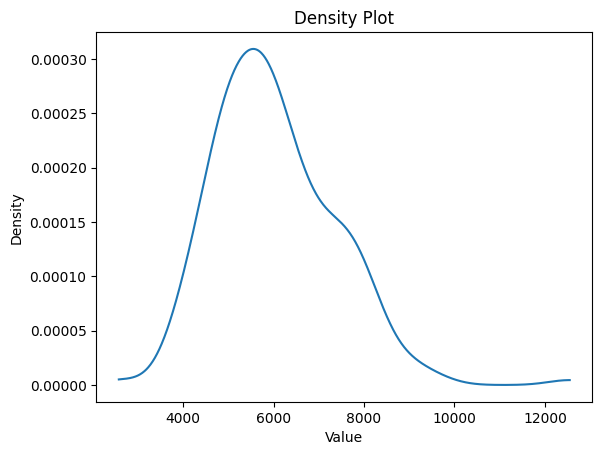

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

print(sum(np.array(spectrum) < 0))

# Create kernel density estimate
kde = gaussian_kde(spectrum)

# Create x values for the plot
x = np.linspace(min(spectrum), max(spectrum), 1000)

# Compute the density estimate
density = kde(x)

# Plot density estimate as a line
plt.plot(x, density)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot')

###put everything in one plot

In [74]:
def plot_fn(spectrums: list, names: list, epoch: int):
  fig, ax = plt.subplots()
  # Create kernel density estimate
  for spectrum, name in zip(spectrums,names):
    kde = gaussian_kde(spectrum)

    # Create x values for the plot
    x = np.linspace(min(spectrum), max(spectrum), 1000)

    # Compute the density estimate
    density = kde(x)

    # Plot density estimate as a line
    ax.plot(x, density, label=name)

  # Add labels and title
  ax.set_xlabel('Max Eigenvalue')
  ax.set_ylabel('Density')
  ax.set_title('Density plot of max eigenvalues at epoch ' + str(epoch))
  ax.legend()
  plt.show()

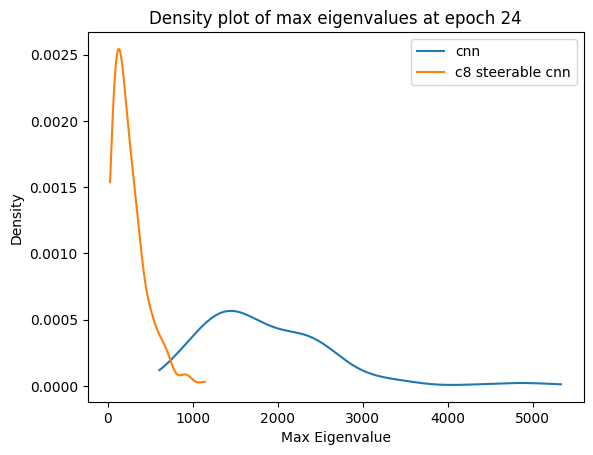

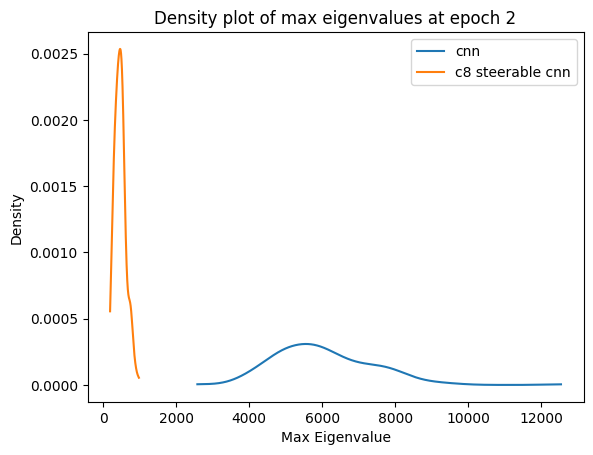

In [77]:
cnn_epoch2 = [6875.40625, 5458.1083984375, 4423.2001953125, 4683.611328125, 5941.65283203125, 4858.1328125, 4823.703125, 5896.98828125, 5852.12109375, 5031.59228515625, 5160.06298828125, 4729.49462890625, 4687.4990234375, 8037.125, 5394.51513671875, 4012.002685546875, 5615.88818359375, 6808.6826171875, 6529.435546875, 5828.2626953125, 6375.70263671875, 6066.27734375, 3965.632568359375, 4112.02783203125, 6158.7685546875, 6011.3955078125, 5706.56689453125, 4558.5634765625, 4919.46875, 4116.5576171875, 5973.62158203125, 4209.6865234375, 7843.30224609375, 5642.18896484375, 6206.28515625, 5202.30810546875, 7452.43408203125, 5710.0068359375, 7445.5595703125, 4984.33203125, 8024.2041015625, 7435.71826171875, 6818.78564453125, 6401.49365234375, 5641.6650390625, 7815.703125, 4988.9267578125, 6618.49169921875, 5833.705078125, 5644.5712890625, 7210.99267578125, 6100.619140625, 7903.171875, 5609.67724609375, 9615.8232421875, 5828.18701171875, 3833.476318359375, 7533.93701171875, 6343.1982421875, 5757.0361328125, 5240.94384765625, 7500.3837890625, 8404.8544921875, 6103.01123046875, 5035.01416015625, 5455.63916015625, 5202.40966796875, 4872.60546875, 5992.033203125, 9025.474609375, 4555.62060546875, 6732.37646484375, 6664.4228515625, 8437.919921875, 8140.16064453125, 4803.15380859375, 5537.908203125, 7520.40966796875, 9194.26171875, 6405.05615234375, 5738.361328125, 4769.97705078125, 7116.65087890625, 4839.0634765625, 5039.64306640625, 5679.08447265625, 5501.91162109375, 6773.61083984375, 7073.40234375, 6215.61767578125, 12549.6103515625, 5246.15087890625, 4800.44873046875, 2576.76611328125, 4823.91015625, 8342.9296875, 5892.50390625, 6700.95361328125, 4060.697265625, 5781.48388671875, 5207.65771484375, 7800.92822265625, 5595.53857421875, 6312.095703125, 5106.3603515625, 7603.74951171875, 5499.97509765625, 4950.3359375, 5303.32373046875, 5097.0166015625, 5528.58154296875, 5350.11083984375, 5879.474609375, 5749.6787109375, 4464.69091796875, 4241.6728515625, 3762.043701171875, 4796.3291015625, 4872.37255859375, 6653.833984375, 7951.5654296875, 4945.408203125, 4874.1982421875, 5586.96630859375, 6442.841796875, 7207.982421875, 6233.39599609375, 6085.5615234375, 7803.0146484375, 5554.30126953125, 5043.337890625, 6850.36767578125, 4261.89794921875, 5584.1748046875, 6318.6123046875, 7457.54296875, 5151.49951171875, 6157.54931640625, 7693.1611328125, 6201.69482421875, 4867.462890625, 8440.51171875, 4419.93408203125, 4183.197265625, 4575.37548828125, 7047.0185546875, 7283.37451171875, 5314.14794921875, 5808.33154296875, 5411.41796875, 5687.88525390625, 6820.060546875, 6485.29638671875, 7957.88671875, 6337.58447265625, 4017.68798828125, 6778.3818359375, 5335.61279296875, 7552.31689453125, 7063.775390625, 7346.70849609375, 5066.396484375, 4531.8134765625, 4710.28173828125, 6924.7734375, 7473.9931640625, 5783.69921875, 7789.40283203125, 4608.96875, 6278.18408203125, 5102.08056640625, 7899.7890625, 5188.20458984375, 6280.3212890625, 6939.212890625, 6125.77197265625, 6051.2744140625, 5465.64013671875, 7250.2724609375, 4638.0947265625, 6418.1240234375, 5552.11962890625, 8209.287109375, 5717.70654296875, 8915.33984375, 8058.36962890625, 6196.37109375, 4062.49560546875]
cnn_epoch24 = [2275.118408203125, 1095.6337890625, 1039.4385986328125, 2222.73876953125, 1411.3935546875, 875.824951171875, 1904.9405517578125, 1949.60791015625, 2553.19970703125, 1305.8563232421875, 1030.135986328125, 1272.5654296875, 1916.4949951171875, 1468.9964599609375, 895.3472900390625, 1440.815185546875, 1127.07666015625, 1392.247802734375, 2330.771728515625, 608.7413330078125, 2996.583740234375, 3431.375732421875, 1156.906494140625, 898.31689453125, 1904.0301513671875, 2993.462890625, 1316.552001953125, 1383.8214111328125, 2872.70947265625, 2868.049560546875, 1806.08154296875, 729.8719482421875, 1321.500732421875, 1907.0887451171875, 1626.5419921875, 1356.6319580078125, 2472.715087890625, 1448.74658203125, 1383.6541748046875, 1575.610107421875, 2452.189697265625, 2792.68994140625, 2271.71142578125, 1328.8927001953125, 1576.3148193359375, 2436.5751953125, 1139.0185546875, 1186.6630859375, 4752.67431640625, 1992.92431640625, 2231.489013671875, 1201.863525390625, 741.259765625, 1332.9908447265625, 2264.212646484375, 4296.353515625, 775.919189453125, 2617.020751953125, 1475.970458984375, 1383.945556640625, 2079.74267578125, 987.4376831054688, 1174.7044677734375, 1706.98388671875, 1339.1964111328125, 1763.966064453125, 1365.6197509765625, 1363.8260498046875, 2337.251708984375, 1142.4588623046875, 856.9503784179688, 2870.81689453125, 5025.41015625, 2484.961669921875, 1460.8349609375, 1588.71875, 1029.816162109375, 1856.9176025390625, 1057.73974609375, 2549.375732421875, 969.8262939453125, 1673.4315185546875, 2536.720947265625, 1189.735595703125, 842.6403198242188, 1157.396240234375, 1539.49609375, 1925.9476318359375, 956.359130859375, 2393.259033203125, 2308.452880859375, 1346.31787109375, 1953.202880859375, 2076.034423828125, 1388.024658203125, 2606.22265625, 2092.852294921875, 1794.3182373046875, 910.8128051757812, 2985.702392578125, 1121.739990234375, 3338.694580078125, 1385.4969482421875, 1475.760498046875, 1523.9459228515625, 2316.929443359375, 1666.53466796875, 1805.6136474609375, 1798.634033203125, 1436.483154296875, 1543.68798828125, 1779.47998046875, 1579.802001953125, 1751.056884765625, 1636.9447021484375, 1938.5516357421875, 1515.407958984375, 1292.427001953125, 2660.054443359375, 2108.15673828125, 2486.980224609375, 1794.8109130859375, 2224.41796875, 2105.936767578125, 2384.95166015625, 3319.75, 1595.4737548828125, 2444.44775390625, 1833.89013671875, 1174.57470703125, 2652.756103515625, 2328.857177734375, 1845.059326171875, 2665.083740234375, 4761.80810546875, 1819.90087890625, 2244.44580078125, 2171.89794921875, 2436.1630859375, 1565.2130126953125, 2296.580810546875, 2446.5986328125, 1551.7867431640625, 2382.902587890625, 1773.6556396484375, 2630.6806640625, 1756.77734375, 1127.5264892578125, 2086.9296875, 1598.426513671875, 2118.333984375, 1417.4432373046875, 1391.093017578125, 2123.302490234375, 1912.5367431640625, 1849.6383056640625, 2458.71337890625, 1643.869873046875, 3266.890869140625, 1487.9603271484375, 2364.990234375, 1210.434326171875, 826.3599853515625, 1864.6097412109375, 1405.7088623046875, 1469.961669921875, 1539.8736572265625, 2638.4970703125, 827.0991821289062, 868.0311279296875, 2297.556396484375, 5333.80224609375, 1841.739013671875, 1316.693359375, 3573.09130859375, 2613.081787109375, 1187.273681640625, 1013.5319213867188, 2179.75634765625, 1148.74658203125, 2292.6611328125, 1079.3045654296875, 1223.306884765625, 2630.29296875, 2276.338134765625, 1363.71630859375, 1543.708984375, 1406.6788330078125]

scnn_epoch2 =[333.031982421875, 254.37513732910156, 395.8107604980469, 287.7648010253906, 401.6199951171875, 414.1491394042969, 410.441162109375, 498.984619140625, 530.0369262695312, 296.0187072753906, 387.8148498535156, 274.1049499511719, 766.5582885742188, 465.79052734375, 422.53411865234375, 417.55615234375, 403.8988952636719, 532.3838500976562, 720.0921630859375, 479.35028076171875, 528.6215209960938, 454.8970947265625, 397.3937683105469, 409.3011474609375, 329.2708435058594, 510.29620361328125, 758.2106323242188, 740.628662109375, 572.430419921875, 692.5631103515625, 520.3715209960938, 182.6204833984375, 590.7817993164062, 523.0174560546875, 613.02099609375, 503.0660400390625, 579.7132568359375, 490.16015625, 331.343994140625, 418.6534118652344, 438.0970458984375, 506.46990966796875, 538.7897338867188, 290.7578430175781, 413.21563720703125, 481.84820556640625, 541.3834838867188, 677.215576171875, 747.4902954101562, 467.7528076171875, 739.9113159179688, 560.5393676757812, 512.3710327148438, 303.5492248535156, 610.9276123046875, 316.61871337890625, 221.5895233154297, 362.7914733886719, 313.8654479980469, 872.2951049804688, 458.436279296875, 263.7212219238281, 484.5103454589844, 399.1614685058594, 738.9041748046875, 272.5138244628906, 458.6981201171875, 303.18414306640625, 393.77984619140625, 328.2042541503906, 413.8892822265625, 642.6610717773438, 641.008544921875, 874.1571655273438, 372.827392578125, 529.0104370117188, 268.7242736816406, 481.32318115234375, 482.2596130371094, 510.3630065917969, 427.1429748535156, 433.3789978027344, 408.65167236328125, 223.23452758789062, 231.7783203125, 491.7130126953125, 443.9861145019531, 483.562255859375, 264.6827087402344, 370.2630615234375, 292.4689636230469, 261.6284484863281, 372.6754455566406, 557.0153198242188, 802.7447509765625, 423.7261047363281, 359.6263122558594, 329.3255310058594, 515.5411376953125, 511.0309143066406, 198.85968017578125, 303.0186462402344, 411.8247375488281, 729.6478881835938, 412.2502136230469, 336.8749084472656, 726.7825927734375, 622.3912963867188, 484.619384765625, 269.9864807128906, 386.95208740234375, 552.688232421875, 477.0025634765625, 511.48223876953125, 429.30340576171875, 257.7005615234375, 347.59210205078125, 307.7939147949219, 592.5737915039062, 657.2743530273438, 601.2853393554688, 247.1113739013672, 334.7955627441406, 576.3949584960938, 588.1029663085938, 529.8814697265625, 365.58721923828125, 571.9590454101562, 476.028564453125, 335.2339782714844, 471.9889831542969, 770.2286987304688, 665.1209716796875, 565.0595703125, 822.701171875, 531.0625, 973.8545532226562, 410.9610595703125, 789.7733154296875, 537.3961791992188, 452.2750244140625, 544.9236450195312, 328.4250183105469, 430.4637451171875, 573.8278198242188, 355.9228515625, 441.9842529296875, 378.67327880859375, 444.3838806152344, 477.47955322265625, 556.3922729492188, 315.4058837890625, 495.8985595703125, 368.0945739746094, 419.21917724609375, 579.9761352539062, 332.9350280761719, 502.3441467285156, 336.343505859375, 460.5832214355469, 240.65048217773438, 189.80686950683594, 367.5255126953125, 215.28997802734375, 536.4002075195312, 451.96917724609375, 307.2962646484375, 248.85569763183594, 218.47706604003906, 278.7452087402344, 738.1245727539062, 520.2979125976562, 330.4383850097656, 277.6267395019531, 425.00018310546875, 381.9191589355469, 466.0438232421875, 513.95556640625, 673.2568969726562, 510.0746154785156, 650.2837524414062, 188.16029357910156, 271.6206359863281, 381.33868408203125, 494.6335144042969, 356.8428649902344, 360.6876220703125, 568.6244506835938]
scnn_epoch24 = [314.642333984375, 173.0394744873047, 251.52407836914062, 224.0927276611328, 289.7452697753906, 518.0335693359375, 70.21331787109375, 133.7662353515625, 174.97073364257812, 242.20401000976562, 75.68696594238281, 141.51077270507812, 211.8843994140625, 254.21253967285156, 408.58538818359375, 347.27166748046875, 231.11448669433594, 70.58531951904297, 200.52410888671875, 253.30239868164062, 142.2261505126953, 507.2702331542969, 374.36279296875, 234.97105407714844, 37.048274993896484, 709.0480346679688, 309.60760498046875, 174.18565368652344, 508.20440673828125, 348.5980224609375, 377.426513671875, 79.34432220458984, 150.40591430664062, 62.91594696044922, 89.2257308959961, 123.99053955078125, 182.80841064453125, 535.4548950195312, 499.47601318359375, 732.4172973632812, 82.8945083618164, 92.45112609863281, 282.131591796875, 86.27645111083984, 75.18305206298828, 413.90423583984375, 114.23973846435547, 889.9210815429688, 318.5820617675781, 586.5587158203125, 450.68701171875, 150.817626953125, 312.25372314453125, 383.4609680175781, 362.8493957519531, 532.34765625, 274.8279724121094, 166.28546142578125, 49.724098205566406, 463.49322509765625, 106.7916488647461, 92.72545623779297, 728.14404296875, 118.90805053710938, 700.1868896484375, 239.196044921875, 181.5623779296875, 512.6734008789062, 586.2227172851562, 267.2084045410156, 200.5968780517578, 56.24433898925781, 85.43285369873047, 151.36549377441406, 141.33209228515625, 480.5205078125, 345.6182861328125, 113.46076965332031, 185.97796630859375, 441.51708984375, 95.9354248046875, 631.320068359375, 676.0302124023438, 36.419639587402344, 175.99636840820312, 91.646484375, 242.6637725830078, 295.6427001953125, 153.91709899902344, 77.33868408203125, 113.58612823486328, 228.50839233398438, 358.5420837402344, 346.5455322265625, 644.94189453125, 139.03628540039062, 179.16546630859375, 314.6929626464844, 171.4453887939453, 116.79743194580078, 109.5234603881836, 311.95220947265625, 155.49615478515625, 911.0560302734375, 303.4095153808594, 201.7030487060547, 619.3152465820312, 158.49351501464844, 103.769775390625, 116.8880615234375, 380.30511474609375, 498.2089538574219, 82.62061309814453, 340.9488830566406, 177.7736053466797, 30.15569305419922, 519.9591064453125, 295.7077331542969, 296.7663269042969, 950.8773193359375, 203.52793884277344, 186.70701599121094, 181.02883911132812, 263.6725158691406, 243.75843811035156, 180.3946990966797, 315.0299072265625, 608.1897583007812, 245.5016326904297, 50.253395080566406, 55.26443099975586, 249.5272979736328, 147.0072479248047, 96.0326156616211, 280.4730529785156, 247.1970977783203, 397.70416259765625, 383.3400573730469, 74.02103424072266, 75.7012939453125, 1144.8358154296875, 102.35597229003906, 193.84149169921875, 82.64066314697266, 97.4927978515625, 142.8053436279297, 137.12156677246094, 372.5215148925781, 322.0830993652344, 448.4815368652344, 188.78372192382812, 239.43112182617188, 59.15226745605469, 330.9130554199219, 134.79830932617188, 230.75701904296875, 44.7327995300293, 84.60397338867188, 56.85826110839844, 44.78538513183594, 199.33502197265625, 33.233089447021484, 384.9004821777344, 68.20487976074219, 51.88193893432617, 198.47805786132812, 60.4770622253418, 55.7204475402832, 56.83805465698242, 28.10547637939453, 367.2054138183594, 262.2610778808594, 45.478084564208984, 134.99961853027344, 83.70127868652344, 127.74578094482422, 327.6318359375, 646.6409301757812, 179.415771484375, 438.2740783691406, 45.22396469116211, 42.39576721191406, 109.94139099121094, 123.7861557006836, 190.0303192138672, 82.54149627685547, 139.28213500976562, 302.4882507324219]

plot_fn([cnn_epoch24, scnn_epoch24], ['cnn', 'c8 steerable cnn'], 24)
plot_fn([cnn_epoch2, scnn_epoch2], ['cnn', 'c8 steerable cnn'], 2)


